In [1]:
import implicit 
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import glob
import time
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import os
import statistics
from scipy.sparse import csr_matrix

In [2]:
#os.environ["OPENBLAS_NUM_THREADS"] = "1"
#os.environ["GOTO_NUM_THREADS"] = "1"
#os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
data = pd.read_csv('/media/root/data/swiggy/flipkart/data2/ppv2.csv')
print("Data read.")

Data read.


In [ ]:
data = pd.read_csv('/media/root/data/swiggy/flipkart/data2/ppv2.csv')
print("Data read.")

In [4]:
print(data.columns)

Index(['product_id', 'count', 'analytic_business_unit', 'cms_vertical',
       'account_id_enc'],
      dtype='object')


In [5]:
#First creating required sparse csr matrix
import scipy
products = data.product_id.unique()
accounts = data.account_id_enc.unique()
verticals = data.cms_vertical.unique()

print("No of products is: ",len(products))
print("No of accounts is: ",len(accounts))
print("No of verticals is: ",len(verticals))

prod_to_int = {}
acc_to_int = {}
int_to_prod = {}
int_to_acc = {}
vert_to_int = {}
int_to_vert = {}

count=0
for prod in products:
    prod_to_int[prod] = count
    int_to_prod[count] = prod
    count += 1

count=0
for acc in accounts:
    acc_to_int[acc] = count
    int_to_acc[count] = acc
    count += 1
    
count=0
for vert in verticals:
    vert_to_int[vert] = count
    int_to_vert[count] = vert
    count += 1
    

No of products is:  10032224
No of accounts is:  2323658
No of verticals is:  3288


In [7]:
data['count'].describe()

count    1.958053e+08
mean     1.499054e+00
std      3.692193e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.679000e+04
Name: count, dtype: float64

In [9]:
start_time = time.time()
print("Preprocessing started")
df_acc_to_int = pd.DataFrame(acc_to_int.items(), columns=['account_id', 'account_index'])
print("Step 1 done")
df_vert_to_int = pd.DataFrame(vert_to_int.items(),columns=['cms_vertical','vertical_index'])
print("Step 2 done")
data_userIdx = pd.merge(data, df_acc_to_int, left_on=['account_id_enc'], right_on = ['account_id'])
print("Step 3 done")
data_user_vertIdx = pd.merge(data_userIdx,df_vert_to_int,left_on=['cms_vertical'],right_on=['cms_vertical'])
print("Step 4 done")
print("Preprocessing done.")
print("Time taken ->", time.time() - start_time)

Preprocessing started
Step 1 done
Step 2 done
Step 3 done
Step 4 done
Preprocessing done.
Time taken -> 565.8410403728485


In [13]:
print(data_user_vertIdx.head())

      product_id  count analytic_business_unit cms_vertical  \
0  9780005331927      1                    BGM         book   
1  9788126708635      1                    BGM         book   
2  9789387464506      2                    BGM         book   
3  9788171197415      1                    BGM         book   
4  9789352291328      1                    BGM         book   

                     account_id_enc                        account_id  \
0  46d8931f4aee076458b4183784d798cc  46d8931f4aee076458b4183784d798cc   
1  46d8931f4aee076458b4183784d798cc  46d8931f4aee076458b4183784d798cc   
2  46d8931f4aee076458b4183784d798cc  46d8931f4aee076458b4183784d798cc   
3  46d8931f4aee076458b4183784d798cc  46d8931f4aee076458b4183784d798cc   
4  46d8931f4aee076458b4183784d798cc  46d8931f4aee076458b4183784d798cc   

   account_index  vertical_index  
0              0               0  
1              0               0  
2              0               0  
3              0               0  
4      

In [27]:
df_store = data_user_vertIdx.groupby(['account_index','vertical_index'],as_index=False).sum()
print(df_store.head())

   account_index  vertical_index  count
0              0               0     32
1              0             924      4
2              0            1135     21
3              0            1230      9
4              0            1501      3


In [29]:
print(df_store.columns)
rows = np.array(df_store['account_index'])
cols = np.array(df_store['vertical_index'])
values = np.array(df_store['count'])

sparseMatrix = csr_matrix((values, (cols, rows)), shape = ( len(verticals),len(accounts)))



Index(['account_index', 'vertical_index', 'count'], dtype='object')


In [30]:
matrix_size = sparseMatrix.shape[0]*sparseMatrix.shape[1] # Number of possible interactions in the matrix
num_purchases = len(sparseMatrix.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
print(sparsity)


99.45856157354329


In [31]:
model = implicit.als.AlternatingLeastSquares(factors=50)
model.fit(sparseMatrix)

  0%|          | 0/15 [00:00<?, ?it/s]

In [33]:
item_vecs = model.item_factors
user_vecs = model.user_factors
print('Shape of item vector matrix : ', item_vecs.shape)
print('Shape of User vector matrix : ', user_vecs.shape)

Shape of item vector matrix :  (3288, 50)
Shape of User vector matrix :  (2323658, 50)


In [34]:
np.save('user_feature.npy',user_vecs)
np.save('item_feature.npy',item_vecs)

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator
import seaborn as sns

/media/root/data/swiggy/miniconda3/envs/venv/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [134]:
start_time = time.time()
print("Clustering started")
kmeans = KMeans(n_clusters=20,random_state=0).fit(user_vecs)

np.save('labels.npy',kmeans.labels_)
np.save('centers.npy',kmeans.cluster_centers_)
print("Clustering done.")
print("Time taken ->", time.time() - start_time)

Clustering started
Clustering done.
Time taken -> 401.37528371810913


In [135]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_
print(labels.shape)
(unique, counts) = np.unique(labels, return_counts=True)
print(labels.shape)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

(2323658,)
(2323658,)
[[     0 139031]
 [     1  99279]
 [     2 124380]
 [     3  45123]
 [     4  83780]
 [     5  72258]
 [     6 131636]
 [     7  69426]
 [     8 418712]
 [     9  54186]
 [    10 153018]
 [    11  36454]
 [    12 303283]
 [    13  90210]
 [    14  91133]
 [    15  86850]
 [    16  99289]
 [    17  66279]
 [    18  67700]
 [    19  91631]]


In [41]:
shopsy_dataset = pd.read_csv('/media/root/data/swiggy/flipkart/data2/reseller_profile.csv')
print(shopsy_dataset['s.account_id_enc'].nunique())
print(shopsy_dataset['s.product_id'].nunique())
print(shopsy_dataset.shape[0])

shopsy_user_vertical= shopsy_dataset.groupby(['s.account_id_enc','o.analytic_vertical'],as_index=False).agg({'s.order_item_id_enc':'count'})
print("user vertical combination in shopsy", shopsy_user_vertical.shape[0])

297751
328611
1259873
user vertical combination in shopsy 811757


In [108]:
from random import sample

def intersection(lst1, lst2):
    store = list(set(lst1) & set(lst2))
    return len(store)

def find_common_shopsy(c1):
    mean_items_bought = 0
    user_idx = shopsy_click_users['account_index'].unique()
    user_idx = sample(list(user_idx),20000)
    start_time = time.time()
    for user in user_idx:
        item_interest = np.dot(item_vecs,user_vecs[user].reshape(-1, 1)).reshape(-1)
        pred_items = (-item_interest).argsort()[:c1]
        actual_items = shopsy_click_users[shopsy_click_users['account_index']==user]
        items_bought = actual_items['vertical_index_y'].unique()
        frac_actually_bought = intersection(items_bought,pred_items)/c1
        mean_items_bought += frac_actually_bought 
    mean_items_bought = mean_items_bought/len(user_idx)
    print("Mean item fraction brought: ",mean_items_bought)
    print("Time taken ->", time.time() - start_time)
    return mean_items_bought
values = [1,2,4,5,10,20,50,100]
store = [ find_common_shopsy(v) for v in values]
print(store)

Sampling done
Mean item fraction brought:  0.15285
Time taken -> 27.331515550613403
Sampling done
Mean item fraction brought:  0.13155
Time taken -> 27.416813135147095
Sampling done
Mean item fraction brought:  0.106425
Time taken -> 25.99855089187622
Sampling done
Mean item fraction brought:  0.09836000000001455
Time taken -> 25.982348203659058
Sampling done
Mean item fraction brought:  0.07295999999999206
Time taken -> 25.990940809249878
Sampling done
Mean item fraction brought:  0.04874749999998925
Time taken -> 26.04105854034424
Sampling done
Mean item fraction brought:  0.024417999999996418
Time taken -> 26.138896465301514
Sampling done
Mean item fraction brought:  0.013208499999997896
Time taken -> 26.245589017868042
[0.15285, 0.13155, 0.106425, 0.09836000000001455, 0.07295999999999206, 0.04874749999998925, 0.024417999999996418, 0.013208499999997896]


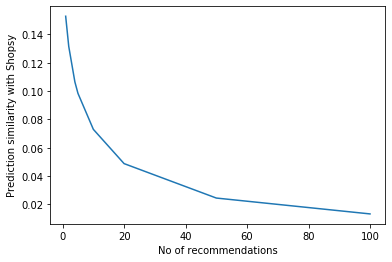

In [110]:
plt.plot(values,store)
plt.xlabel('No of recommendations')
plt.ylabel('Prediction similarity with Shopsy')
plt.savefig("../plots/shopsy_sim.png")

In [76]:
shopsy_user_vertical_encode_temp = pd.merge(shopsy_user_vertical, df_acc_to_int, left_on=['s.account_id_enc'], right_on = ['account_id'])

func = lambda s: s[:1].lower() + s[1:] if s else ''

shopsy_user_vertical_encode_temp['o.analytic_vertical'] = shopsy_user_vertical_encode_temp['o.analytic_vertical'].apply(func)

shopsy_user_vertical_encode = pd.merge(shopsy_user_vertical_encode_temp, df_vert_to_int, left_on=['o.analytic_vertical'], right_on = ['cms_vertical'],how='inner')
shopsy_click_users = pd.merge(data_user_vertIdx, shopsy_user_vertical_encode, right_on=['account_index','cms_vertical'], left_on = ['account_index','cms_vertical'],how='inner')

print(shopsy_click_users.head())

      product_id  count analytic_business_unit cms_vertical  \
0  9780007282463      1                    BGM         book   
1  9789353043636      3                    BGM         book   
2  9780099518440      3                    BGM         book   
3  9788175994225      5                    BGM         book   
4  9788176060462      1                    BGM         book   

                     account_id_enc                      account_id_x  \
0  fd442e903852cf65d65e1c0c0f6734db  fd442e903852cf65d65e1c0c0f6734db   
1  fd442e903852cf65d65e1c0c0f6734db  fd442e903852cf65d65e1c0c0f6734db   
2  fd442e903852cf65d65e1c0c0f6734db  fd442e903852cf65d65e1c0c0f6734db   
3  fd442e903852cf65d65e1c0c0f6734db  fd442e903852cf65d65e1c0c0f6734db   
4  fd442e903852cf65d65e1c0c0f6734db  fd442e903852cf65d65e1c0c0f6734db   

   account_index  vertical_index_x                  s.account_id_enc  \
0              2                 0  fd442e903852cf65d65e1c0c0f6734db   
1              2                 0  fd

In [137]:
def intersection(lst1, lst2):
    lst1.sort()
    set2 = set(lst2)
    common=0
    for item in lst1:
        if item in set2:
            common += 1
    return common/len(lst1)

def check_for_cluster(c1):
    mean_arr1 = []
    start_time = time.time()
    for c in range(0,20):
        cluster_index = np.where(labels==c)
        mean_items_bought = 0
        user_idx = cluster_index[0]
        user_idx = sample(list(user_idx),25000)
        cluster_item = np.dot(item_vecs,centers[c].reshape(-1,1)).reshape(-1)
        pred_center = (-cluster_item).argsort()[:c1]
        for user in user_idx:    
            item_interest = np.dot(item_vecs,user_vecs[user].reshape(-1, 1)).reshape(-1)
            pred_items = (-item_interest).argsort()[:c1]
            frac_actually_bought = intersection(items_bought,pred_items)
            mean_items_bought += frac_actually_bought 
        mean_items_bought = mean_items_bought/len(user_idx)
        mean_arr1.append(mean_items_bought)
    results = np.mean(np.array(mean_items_bought))
    print("Mean item fraction brought: ",results)
    print("Time taken ->", time.time() - start_time)
    return results

values = [1,2,4,5,10,20,50,100]
center_sim = [ check_for_cluster(v) for v in values]
print(center_sim)

Mean item fraction brought:  0.00512
Time taken -> 100.99179291725159
Mean item fraction brought:  0.00968
Time taken -> 96.70566582679749
Mean item fraction brought:  0.01988
Time taken -> 96.78916335105896
Mean item fraction brought:  0.02284
Time taken -> 96.94307494163513
Mean item fraction brought:  0.03964
Time taken -> 97.39696907997131
Mean item fraction brought:  0.07092
Time taken -> 97.7311782836914
Mean item fraction brought:  0.16148
Time taken -> 99.73670220375061
Mean item fraction brought:  0.25968
Time taken -> 103.00068163871765
[0.00512, 0.00968, 0.01988, 0.02284, 0.03964, 0.07092, 0.16148, 0.25968]


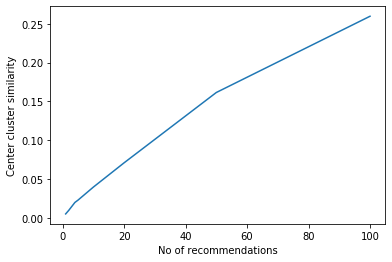

In [138]:
plt.plot(values,center_sim)
plt.xlabel('No of recommendations')
plt.ylabel('Center cluster similarity')
plt.savefig("../plots/cluster_cent.png")

In [139]:
def jaccardian(lst1,lst2):
    lst1.sort()
    lst2.sort()
    i = 0
    j = 0
    common = 0
    while(i<len(lst1) and j<len(lst2)):
        if(lst1[i]>lst2[j]):
            j += 1
        elif(lst1[i]<lst2[j]):
            i += 1
        else:
            i += 1
            j += 1
            common += 1
    return common/(len(lst1)+len(lst2) - common)
            
def check_pairwise(c1):
    mean_arr1 = []
    start_time = time.time()
    for c in range(0,20):
        cluster_index = np.where(labels==c)
        mean_items_bought = 0
        user_idx = cluster_index[0]
        user_idx_1 = sample(list(user_idx),25000)
        user_idx_2 = sample(list(user_idx),25000)
        
        arr1 = []
        
        for i in range(0,25000):
            item_interest = np.dot(item_vecs,user_vecs[user_idx_1[i]].reshape(-1, 1)).reshape(-1)
            pred_items_1 = (-item_interest).argsort()[:c1]
            item_interest = np.dot(item_vecs,user_vecs[user_idx_2[i]].reshape(-1, 1)).reshape(-1)
            pred_items_2 = (-item_interest).argsort()[:c1]
            arr1.append(intersection(pred_items_1,pred_items_2))
        mean_items_bought = np.mean(np.array(arr1))
        mean_arr1.append(mean_items_bought)
    result = np.mean(np.array(mean_arr1))
    print("Mean item fraction brought: ",result)
    print("Time taken ->", time.time() - start_time)
    return result

values = [1,2,4,5,10,20,50,100]
pairwise_sim = [ check_pairwise(v) for v in values]
print(pairwise_sim)

Mean item fraction brought:  0.179116
Time taken -> 205.14967894554138
Mean item fraction brought:  0.223529
Time taken -> 197.94775795936584
Mean item fraction brought:  0.25139700000000004
Time taken -> 195.19112038612366
Mean item fraction brought:  0.25586040000000004
Time taken -> 198.4999396800995
Mean item fraction brought:  0.27022540000000006
Time taken -> 194.1580901145935
Mean item fraction brought:  0.2815477
Time taken -> 195.26968550682068
Mean item fraction brought:  0.30492432
Time taken -> 199.59020280838013
Mean item fraction brought:  0.34096289999999996
Time taken -> 206.84351873397827
[0.179116, 0.223529, 0.25139700000000004, 0.25586040000000004, 0.27022540000000006, 0.2815477, 0.30492432, 0.34096289999999996]


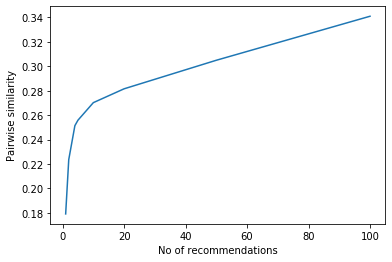

In [140]:
plt.plot(values,pairwise_sim)
plt.xlabel('No of recommendations')
plt.ylabel('Pairwise similarity')
plt.savefig("../plots/pairwise.png")

In [ ]:
#New test results from below. Firstly resuming from cluster center and then pairwise similarity.


In [141]:
def intersection(lst1, lst2):
    lst1.sort()
    set2 = set(lst2)
    common=0
    for item in lst1:
        if item in set2:
            common += 1
    return common/len(lst1)

def check_for_cluster2(c1):
    mean_arr1 = []
    start_time = time.time()
    for c in range(0,20):
        cluster_index = np.where(labels==c)
        mean_items_bought = 0
        user_idx = cluster_index[0]
        user_idx = sample(list(user_idx),25000)
        cluster_item = np.dot(item_vecs,centers[c].reshape(-1,1)).reshape(-1)
        pred_center = (-cluster_item).argsort()[:c1]
        for user in user_idx:    
            item_interest = np.dot(item_vecs,user_vecs[user].reshape(-1, 1)).reshape(-1)
            pred_items = (-item_interest).argsort()[:c1]
            frac_actually_bought = intersection(items_bought,pred_items)
            if  frac_actually_bought > 0 :
                mean_items_bought += 1 
        mean_items_bought = mean_items_bought/len(user_idx)
        mean_arr1.append(mean_items_bought)
    results = np.mean(np.array(mean_items_bought))
    print("Mean item fraction brought: ",results)
    print("Time taken ->", time.time() - start_time)
    return results

values = [1,2,4,5,10,20,50,100]
center_sim2 = [ check_for_cluster2(v) for v in values]
print(center_sim2)

Mean item fraction brought:  0.00444
Time taken -> 96.69340872764587
Mean item fraction brought:  0.00964
Time taken -> 96.65996146202087
Mean item fraction brought:  0.01788
Time taken -> 96.79027152061462
Mean item fraction brought:  0.02276
Time taken -> 96.95538830757141
Mean item fraction brought:  0.03956
Time taken -> 97.30304312705994
Mean item fraction brought:  0.07212
Time taken -> 97.81439208984375
Mean item fraction brought:  0.16108
Time taken -> 99.64172601699829
Mean item fraction brought:  0.26032
Time taken -> 102.98319697380066
[0.00444, 0.00964, 0.01788, 0.02276, 0.03956, 0.07212, 0.16108, 0.26032]


In [142]:
def jaccardian(lst1,lst2):
    lst1.sort()
    lst2.sort()
    i = 0
    j = 0
    common = 0
    while(i<len(lst1) and j<len(lst2)):
        if(lst1[i]>lst2[j]):
            j += 1
        elif(lst1[i]<lst2[j]):
            i += 1
        else:
            i += 1
            j += 1
            common += 1
    return common/(len(lst1)+len(lst2) - common)
            
def check_pairwise2(c1):
    mean_arr1 = []
    start_time = time.time()
    for c in range(0,20):
        cluster_index = np.where(labels==c)
        mean_items_bought = 0
        user_idx = cluster_index[0]
        user_idx_1 = sample(list(user_idx),25000)
        user_idx_2 = sample(list(user_idx),25000)
        
        arr1 = []
        
        for i in range(0,25000):
            item_interest = np.dot(item_vecs,user_vecs[user_idx_1[i]].reshape(-1, 1)).reshape(-1)
            pred_items_1 = (-item_interest).argsort()[:c1]
            item_interest = np.dot(item_vecs,user_vecs[user_idx_2[i]].reshape(-1, 1)).reshape(-1)
            pred_items_2 = (-item_interest).argsort()[:c1]
            if intersection(pred_items_1,pred_items_2) > 0:
                arr1.append(1)
            else:
                arr1.append(0)
        mean_items_bought = np.mean(np.array(arr1))
        mean_arr1.append(mean_items_bought)
    result = np.mean(np.array(mean_arr1))
    print("Mean item fraction brought: ",result)
    print("Time taken ->", time.time() - start_time)
    return result

values = [1,2,4,5,10,20,50,100]
pairwise_sim2 = [ check_pairwise2(v) for v in values]
print(pairwise_sim2)

Mean item fraction brought:  0.17926599999999998
Time taken -> 194.41235280036926
Mean item fraction brought:  0.393636
Time taken -> 192.48697805404663
Mean item fraction brought:  0.6559
Time taken -> 192.89559698104858
Mean item fraction brought:  0.734554
Time taken -> 193.12487936019897
Mean item fraction brought:  0.9092199999999998
Time taken -> 193.92241954803467
Mean item fraction brought:  0.9764160000000001
Time taken -> 195.15839982032776
Mean item fraction brought:  0.998846
Time taken -> 203.21919584274292
Mean item fraction brought:  0.999992
Time taken -> 206.0729465484619
[0.17926599999999998, 0.393636, 0.6559, 0.734554, 0.9092199999999998, 0.9764160000000001, 0.998846, 0.999992]


In [163]:
store_dataset = shopsy_click_users.groupby("o.analytic_vertical")
store_dataset.count()

count_product_in_vertical = {}
col1 = list(store_dataset['product_id'])
for i in range(0,len(col1)):
    count_product_in_vertical[col1[i][0]]= len(col1[i][1])
print(count_product_in_vertical)

{'adhesive': 513, 'allopathy': 23, 'alta': 1, 'antiseptic': 904, 'apron': 761, 'backpack': 50490, 'balaclava': 195, 'band': 24, 'bar': 1169, 'bed': 509, 'bedsheet': 92640, 'bell': 249, 'bindi': 190, 'blanket': 6698, 'blinds': 12, 'blower': 511, 'blush': 293, 'bong': 56, 'book': 69333, 'boomerang': 2, 'bottle': 46895, 'bouncer': 639, 'briefcase': 5, 'bronzer': 17, 'bucket': 251, 'bulb': 17401, 'calculator': 2063, 'calendar': 2, 'caliper': 79, 'candle': 1169, 'canvas': 382, 'carabiner': 198, 'chainsaw': 212, 'chalk': 306, 'cheese': 33, 'chimney': 1219, 'chips': 344, 'chopper': 10585, 'chowki': 288, 'chyawanprash': 466, 'clamp': 31, 'cleanser': 659, 'clip': 82, 'clothesline': 67, 'coaster': 176, 'coffee': 1998, 'compact': 4339, 'concealer': 1858, 'conditioner': 3619, 'condom': 6577, 'container': 37728, 'cover': 253, 'crayon': 547, 'crimper': 60, 'curtain': 689, 'cutter': 539, 'dart': 12, 'deodorant': 56264, 'diaper': 31299, 'diffuser': 1, 'dimmer': 3, 'diya': 1406, 'drone': 266, 'dumbbell

In [174]:
dataset_abc  = shopsy_click_users.groupby(["account_index","o.analytic_vertical"])
dataset_abc.count()


product_id  count  analytic_business_unit  \
account_index o.analytic_vertical                                              
2             book                         18     18                      18   
9             book                         14     14                      14   
              trimmer                       2      2                       2   
43            deodorant                     2      2                       2   
44            blower                        7      7                       7   
...                                       ...    ...                     ...   
2323379       diaper                        1      1                       1   
2323419       iron                          1      1                       1   
2323425       iron                          1      1                       1   
2323510       pen                           1      1                       1   
2323586       shampoo                       1      1                       1   

                                   cms_vertical  account_id_enc  account_id_x  \
account_index o.analytic_vertical                                               
2             book                           18              18            18   
9             book                           14              14            14   
              trimmer                         2               2             2   
43            deodorant                       2               2             2   
44            blower                          7               7             7   
...                                         ...             ...           ...   
2323379       diaper                          1               1             1   
2323419       iron                            1               1             1   
2323425       iron                            1               1             1   
2323510       pen                             1               1             1   
2323586       shampoo                         1               1             1   

                                   vertical_index_x  s.account_id_enc  \
account_index o.analytic_vertical                                       
2             book                               18                18   
9             book                               14                14   
              trimmer                             2                 2   
43            deodorant                           2                 2   
44            blower                              7                 7   
...                                             ...               ...   
2323379       diaper                              1                 1   
2323419       iron                                1                 1   
2323425       iron                                1                 1   
2323510       pen                                 1                 1   
2323586       shampoo                             1                 1   

                                   s.order_item_id_enc  account_id_y  \
account_index o.analytic_vertical                                      
2             book                                  18            18   
9             book                                  14            14   
              trimmer                                2             2   
43            deodorant                              2             2   
44            blower                                 7             7   
...                                                ...           ...   
2323379       diaper                                 1             1   
2323419       iron                                   1             1   
2323425       iron                                   1             1   
2323510       pen                                    1             1   
2323586       shampoo                                1             1   

                                   vertical_index_y  

In [178]:
acc = list(dataset_abc["account_index"])
vert = list(dataset_abc["o.analytic_vertical"])
counts = list(dataset_abc["product_id"])

In [192]:
map_pairs = {}
for i in range(0,len(acc)):
    map_pairs[(acc[i][0][0],vert_to_int[vert[i][0][1]])] = len(counts[i][1])
    

In [1]:
print(map_pairs)

NameError: name 'map_pairs' is not defined

In [196]:
def intersection_new(lst1, lst2):
    store = list(set(lst1) & set(lst2))
    return store

def find_common_shopsy_2(c1):
    mean_items_bought = 0
    user_idx = shopsy_click_users['account_index'].unique()
    user_idx = sample(list(user_idx),20000)
    start_time = time.time()
    for user in user_idx:
        item_interest = np.dot(item_vecs,user_vecs[user].reshape(-1, 1)).reshape(-1)
        pred_items = (-item_interest).argsort()[:c1]
        actual_items = shopsy_click_users[shopsy_click_users['account_index']==user]
        items_bought = actual_items['vertical_index_y'].unique()
        verticals_bought = intersection_new(items_bought,pred_items)
        for vert1 in verticals_bought:
            mean_items_bought +=  map_pairs[(user,vert1)]
    mean_items_bought = mean_items_bought/len(user_idx)
    print("Mean items amongst vertical brought by user is: ",mean_items_bought)
    print("Time taken ->", time.time() - start_time)
    return mean_items_bought
values = [1,2,4,5,10,20,50,100]
store = [ find_common_shopsy_2(v) for v in values]
print(store)

Mean items amongst vertical brought by user is:  1.12525
Time taken -> 26.653108596801758
Mean items amongst vertical brought by user is:  1.923
Time taken -> 26.847374200820923
Mean items amongst vertical brought by user is:  3.43525
Time taken -> 25.493853092193604
Mean items amongst vertical brought by user is:  4.0129
Time taken -> 25.513455629348755
Mean items amongst vertical brought by user is:  6.02695
Time taken -> 25.54689908027649
Mean items amongst vertical brought by user is:  7.9792
Time taken -> 25.629108667373657
Mean items amongst vertical brought by user is:  9.2904
Time taken -> 25.667429447174072
Mean items amongst vertical brought by user is:  9.7561
Time taken -> 25.833409309387207
[1.12525, 1.923, 3.43525, 4.0129, 6.02695, 7.9792, 9.2904, 9.7561]
